In [1]:
include("../scripts/robot.jl")

In [2]:
using Distributions
using LinearAlgebra

In [3]:
mutable struct Particle
    pose
    weight
end

In [4]:
function motion_update(self::Particle, nu, omega, time, noise_rate_pdf)
    ns = rand(noise_rate_pdf)
    noised_nu = nu + ns[1]*sqrt(abs(nu)/time) + ns[2]*sqrt(abs(omega)/time)
    noised_omega = omega + ns[3]*sqrt(abs(nu)/time) + ns[4]*sqrt(abs(omega)/time)
    self.pose = state_transition(IdealRobot([]), noised_nu, noised_omega, time, self.pose)
end

motion_update (generic function with 1 method)

In [5]:
function observation_update(self::Particle, observation, envmap, distance_dev_rate, direction_dev)
#     print(observation)
    for d in observation
        obs_pos = d[1]
        obs_id = d[2]+1#1-indexed in julia
        
        pos_on_map = envmap.landmarks[obs_id].pos
        particle_suggest_pos = relative_polar_pos(IdealCamera(), self.pose, pos_on_map)
        
        distance_dev = distance_dev_rate*particle_suggest_pos[1]
        cov = Diagonal([distance_dev^2, direction_dev^2])
        self.weight *= pdf(MvNormal(particle_suggest_pos, cov), obs_pos)
    end
end

observation_update (generic function with 1 method)

In [6]:
mutable struct Mcl
    particles
    map
    distance_dev_rate
    direction_dev
    motion_noise_rate_pdf
end

In [7]:
function Mcl_(envmap, init_pose, num, motion_noise_stds=Dict("nn"=>0.19, "no"=>0.001, "on"=>0.13, "oo"=>0.2),
                        distance_dev_rate=0.14, direction_dev=0.05)
    self = Mcl(ntuple(x->nothing, fieldcount(Mcl))...)
    self.particles =[Particle(init_pose, 1.0/num) for i in 1:num-1]
    self.map = envmap
    self.distance_dev_rate = distance_dev_rate
    self.direction_dev = direction_dev
    v = motion_noise_stds
    c = Diagonal([v["nn"]^2, v["no"]^2, v["on"]^2, v["oo"]^2])
    self.motion_noise_rate_pdf = MvNormal(zeros(4), c)
    return self
end

Mcl_ (generic function with 4 methods)

In [8]:
function motion_update(self::Mcl, nu, omega, time)
    for p in self.particles
        motion_update(p, nu, omega, time, self.motion_noise_rate_pdf)
    end
end

motion_update (generic function with 2 methods)

In [9]:
function observation_update(self::Mcl, observation)
    for p in self.particles
        observation_update(p, observation, self.map, self.distance_dev_rate, self.direction_dev)
    end
end

observation_update (generic function with 2 methods)

In [10]:
function draw(self::Mcl, ax, elems)
    xs = [p.pose[1] for p in self.particles]
    ys = [p.pose[2] for p in self.particles]
    vxs = [cos(p.pose[3])*p.weight*length(self.particles) for p in self.particles]
    vys = [sin(p.pose[3])*p.weight*length(self.particles) for p in self.particles]
    elems = vcat(elems, ax.quiver(xs, ys, vxs, vys, angles="xy", scale_units="xy", color="blue", alpha=0.5))
end

draw (generic function with 6 methods)

In [11]:
mutable struct EstimationAgent <: AbstractAgent
    nu
    omega
    estimator
    time_interval
    prev_nu
    prev_omega
end

In [12]:
function  EstimationAgent_(time_interval, nu, omega,estimator)
    self = EstimationAgent(ntuple(x->nothing, fieldcount(EstimationAgent))...)
    self.nu = nu
    self.omega = omega
    self.estimator = estimator
    self.time_interval = time_interval
    self.prev_nu = 0.0
    self.prev_omega = 0.0
    return self
end

EstimationAgent_ (generic function with 1 method)

In [13]:
function decision(self::EstimationAgent, observation=nothing)
    motion_update(self.estimator, self.prev_nu, self.prev_omega, self.time_interval)
    self.prev_nu, self.prev_omega = self.nu, self.omega
    observation_update(self.estimator,observation)
    return self.nu, self.omega
end

decision (generic function with 4 methods)

In [14]:
function draw(self::EstimationAgent, ax, elems)
    draw(self.estimator, ax, elems)
end

draw (generic function with 7 methods)

In [15]:
function trial()
    time_interval = 1.0
    world = World_(30, time_interval, false)
    
    m = Map()
    for ln in [[-4.0, 2.0], [2.0, -3.0], [3.0, 3.0]]
        append_landmark(m, Landmark(ln))
    end
    append(world, m)
    
    initial_pose = [0.0, 0.0, 0.0]
    estimator = Mcl_(m, initial_pose, 100)
    a = EstimationAgent_(time_interval, 0.2, 10.0/180*pi, estimator)
    r = Robot_(initial_pose, sensor=Camera_(m), agent=a, color="red")
    append(world, r)
    draw(world)
    showanim("test.mp4")
end

trial (generic function with 1 method)

<video controls src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQABMAttZGF0AAACoAYF//+c3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE1NyAtIEguMjY0L01QRUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMTggLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xMiBsb29rYWhlYWRfdGhyZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MSBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAAF8JliIQAF//+99S3zLLtU2+2C6j3op4mX0N1JQGblsTtOoAAAAMAAAMAAB68FzgCX4kK868AAAMAyoAXqEn/CmOPiA7BC5NJlvfhKIWPSXi/zA6JYDLoQAMQkgYxW5dmab7XU8OwHbXsgN0pr1Mb3ZVyfb/lB2gi6W+gfRXmXQZM6cMhk2jQY++dL7wLKVHmh0CPxv3+WNGvKm+7Tm+8CdT/3gGUP7LtwTiF5GehKUwO7pAnOzSmJIW1T+a4XuGgb4a2t4L9lSwOFRmVzi+8rRsXxAdfzMMijyB/Ta1wiSuhI79dBR7xJRaBV9ettPpFinp9ZJfk36EhgSh59+B8W2UD3m+Fgvr8VKH/77sWmybD0uCkW2BZsmgkjFAzwksJj5iR1qSp0aXrPPLKi6k36RviyS3PfWwStfI3v5/+38BejYKjbtDWV6TcbvcMdElKt2mGz1E7aVzRTz1y3GLWwVCFpKkZY9Auow6aW7gRQZYt2pyDL+Yi7GtiV+ceFiirgOBFcYopIW99SBW0TIui6TuegxJBsZoeNH9a39+V5z3im2d9XIIXtl5s7c7x6OS59h1zeRSKZzpydJ9635MpbcqOMhu804g7WQuWtBei14rKL43Ot/LhvSaYVWWC+FkuSdkMya6o5iK5ET9wAzaYAeN5t7jE8dpa8y4kROGQiXy0/sMl1X4SWI9mhiiZLqMKFrO4XDkIybpd7mPoU9kfZqsFedqvm8ZnygjuAfWOMOASZZNk6cnN992hxnRUWv+EKi/JdfpqQC08/DM2IHGRlJPmtrN1XmkyiD5aM7Ob6splzane4qwYotU+j7hfHVJfA7lNezkA1ou+KIszMzzTz9RjZUY8RGhGYVk2oJ7gMb7c/9ZvcpBdmex/ltzzYeAmDLDqhxyQ9RyK9/9ysysiZyhiD5MMANMJjmHgYptd6hp9P6dSSKprkwNDj90W1gHi/oTRgAG6RkgGaC1YxCjb+y8NDPKsKanoM8bmyeZIIyGLnjSLlqORMYgLrS/uLGunbnFvN6ifx5UYUEv7g7gGGTonde8zFx/0ggJL6D4/28u8S6YlhIRg4yqJ7hRTtDrFgyAvOw/OXcksoZrhdPGNPuPm/DtK2FCD1Y0SCk79XdHfEupEYr4JwU4VxzmWb+yzec3GpueG4IoUB/9jiU/A08apyP4MOljhJWovlH9gnd2xnZxNsa9Mo6sGRk8X1xpRD9jlACXURxZbrWnf587MMb4XeVqRvLHEL7Jr5SfBfZtnW8orl1PP5X5CLZ6wQgxN2REtIqu3nVFnfIRbhflyD2uAhhJ/JEvkyDpLxFr+PK320ww7qX7q/gikRY8obInrT3Qm8SFHy7PtTwVoManZPEE0NGc4hsMd5VWw1x3Y8Wrwnp4c54/YIG+Gq4bAOLnqRr59e21e7MLzJ6IBVTbitqfPZCyFGkXmLsRE6MLX7ru3uM9fRZHH4srrc5G3VbPuoxO+EBJJ7l9GHXzbgKar6tEmIE61PcZSG1WX4jb/ILlIY7wOR7PHQ/yC24yjxt14tgwOyyGJz1V0VWRPFpzFHx74cKJtLCyiFYS94G4HXge9dH2x+R0oNXvuP264q5UGivfRn961AnY5pkGPlNr/sPWOMacXh/onfIGYHAgFGRXGWkUhpgg6p5JmTVSqdHup92sWoH0PwLDHE1yktiuA1VjasHUnMwgjYgp/FHIcAUwHGRPaLKCG0vXj9qK2EOIepVJCw9ut/J5gTHQsuj82z2Sag8T1Ty52nvqEPOQYkK5sNo+tN3Nfxoz62DOtql04uEL5GpT0Cbee2WVMA8Msoe3M6M44zGmX08oxqG4xNSe1ARH2GDy7R0n8ErTuBdZRWfEUhzaZYF48BqHuWIzDuKYXla7OfHtEdYS51SCC6AW46BHaJuy8JdnbWqSawV8PeCA5FZvPU3rSPoRhneooDTTXTOYp8rZgv6jDpB3pMQaZ6OeNJrEt1zEFjaSZ8Ckv9fynbYUbKKqg23QTJC2aE4w5vK6o2jnBW0F8/3Z7jPsmG/BtQ1r+xmCPlrwUN8uTFXqyOZVFqMFu6s5UtLu3LopuEZOJfk0HEfEwuJINifj66GF/LPxS0LaUeHUyU26Ri46kaBtFxMwoMonTNtgFOIJ6R5qdnaPdvqM9q4MDEfK7bv6UlvAdfIRVXrPKUHpUAp3P/uTD3RpwCVOeAvyE5EMY80PG7LmkGqyYt6Kw3973XrZWDigWtjrVUqibJthcqvR9rMbZQNJDfkAnmdgnM2bVbnhoE94mqpCJmBjkm8pBrizLmiukbk0qbaR2/7r3KASJ4foYuBdcnDfL9YxecjlwanjmAVzIoTcdRumklteTBOjvLBDepp6zvF9ZyrljOm5YY/srrIe55Wju1lzuOUOdFm1Se7YBjK67/VhV6LjrEWc9mRiOUDK2vm4XRz6UD/jzsEzLrWquie/YdVsdjoUP7Z7vWLUFQ3leSFa/PT7WZkij4DXEUEpwyjJs0rPyqGV94X6V4O7iGQnwvSkFiwk1DAftbtih6ggbBMTu9xbkG8V077oJyTjrP/6J5fhaoUx/1E15zyBvkQVrqjTG/3FS7vyBV4bi/u3bqC/ShLn6e0iDMENGB5YZ1XlIRwhXd83MTa6jRF/neXflfBvkLUc03xmiNro/kUzuPWcWy2+VUJB6kuy5FFJFNmcnauEFo4UPSb8NhnKzhoJmPilTMhcW6pNT24yvVIYD00FlALOy8qN54VaiJcCbALitQuGOiJVqaCJNBZDcDuMTcIWgubCFx0prvBcVIkMke+slvY8J8FvVF9YGpdnPDxMXzT96Ew7PPe6fvZiR3/MEEdzf1lYY8s+jsb1y8skcWQCjYrGhdit/hWuoO00cYfZt6RA+6DBP9xaYU1xwtJVWXEkqglHy37v40nos4uoBOPgiCL5zKdq+fmEjhk5g7CIsQ1AJGHvGst/eqf0lM1R7V7Sngeqb8DkQ/JTrNvKJbt62klr

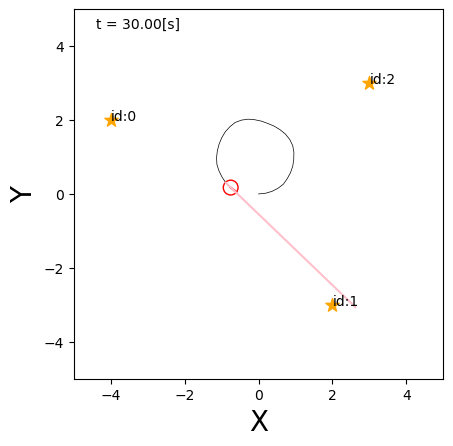

In [16]:
trial()